In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import glob
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

SEED = 69
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
AUTOTUNE = tf.data.AUTOTUNE

2025-10-11 12:54:35.988396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760187276.166446      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760187276.217092      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (480, 480) 
BATCH_SIZE = 64
LEARNING_RATE_HEAD = 3e-4
LEARNING_RATE_FINETUNE = 1e-5
EPOCHS = 30

In [3]:
base_path = "/kaggle/input/lomba-ui"
train_path = os.path.join(base_path, 'Train')

data = []

for label in os.listdir(train_path):
    if label == '.DS_Store':
        continue
    
    label_path = os.path.join(train_path, label)
    for __ in os.listdir(label_path):
        if __ == '.DS_Store':
            continue
        img_path = os.path.join(label_path, __)
        data.append([img_path, label])

df = pd.DataFrame(data, columns=["path", "label"])
df['label'].value_counts()

label
balinese       776
minangkabau    563
javanese       249
batak           95
dayak           69
Name: count, dtype: int64

In [4]:
balinese = ['balinese_train_000245.jpg',
'balinese_train_000721.jpg',
'balinese_train_000179.jpg',
'balinese_train_000541.jpg',
'balinese_train_000556.jpg',
'balinese_train_000341.jpg',
'balinese_train_000157.jpg',
'balinese_train_000429.jpg',
'balinese_train_000417.jpg',
'balinese_train_000775.jpg',
'balinese_train_000205.jpg',
'balinese_train_000201.jpg',
'balinese_train_000389.jpg',
'balinese_train_000648.jpg',
'balinese_train_000489.jpg',
'balinese_train_000667.jpg',
'balinese_train_000538.jpg',
'balinese_train_000664.jpg',
'balinese_train_000665.jpg',
'balinese_train_000473.jpg',
'balinese_train_000301.jpg',
'batak_train_000040.jpg',
'batak_train_000086.jpg',
'batak_train_000001.jpg',
'batak_train_000002.jpg',
'dayak_train_000019.jpg',
'javanese_train_000032.jpg',
'javanese_train_000009.jpg',
'javanese_train_000050.jpg',
'javanese_train_000079.jpg',
'javanese_train_000122.jpg',
'javanese_train_000099.jpg',
'javanese_train_000048.jpg',
'javanese_train_000077.jpg',
'minangkabau_train_000006.jpg',
'minangkabau_train_000005.jpg',
'minangkabau_train_000038.jpg',
'minangkabau_train_000003.jpg',
'minangkabau_train_000299.jpg',
'minangkabau_train_000066.jpg',
'minangkabau_train_000117.jpg',
'minangkabau_train_000079.jpg',
'minangkabau_train_000186.jpg',
'minangkabau_train_000008.jpg']

batak = ['balinese_train_000762.jpg',
'balinese_train_000760.jpg',
'batak_train_000057.jpg',
'batak_train_000043.jpg',
'batak_train_000042.jpg',
'batak_train_000054.jpg',
'batak_train_000045.jpg',
'batak_train_000032.jpg',
'batak_train_000033.jpg',
'batak_train_000007.jpg',
'batak_train_000004.jpg',
'javanese_train_000111.jpg',
'javanese_train_000012.jpg',
'minangkabau_train_000411.jpg']

dayak = ['balinese_train_000032.jpg',
'balinese_train_000764.jpg',
'dayak_train_000058.jpg',
'javanese_train_000085.jpg',
'javanese_train_000213.jpg',
'javanese_train_000015.jpg',
'minangkabau_train_000015.jpg']

javanese = ['balinese_train_000278.jpg',
'balinese_train_000768.jpg',
'balinese_train_000231.jpg',
'balinese_train_000769.jpg',
'balinese_train_000426.jpg',
'balinese_train_000770.jpg',
'balinese_train_000767.jpg',
'balinese_train_000766.jpg',
'batak_train_000092.jpg',
'batak_train_000093.jpg',
'batak_train_000006.jpg',
'batak_train_000010.jpg',
'dayak_train_000052.jpg',
'javanese_train_000150.jpg',
'javanese_train_000178.jpg',
'javanese_train_000024.jpg',
'javanese_train_000025.jpg',
'javanese_train_000186.jpg',
'javanese_train_000152.jpg',
'javanese_train_000220.jpg',
'javanese_train_000157.jpg',
'javanese_train_000169.jpg',
'javanese_train_000035.jpg',
'javanese_train_000222.jpg',
'javanese_train_000053.jpg',
'javanese_train_000247.jpg',
'javanese_train_000121.jpg',
'javanese_train_000041.jpg',
'javanese_train_000096.jpg',
'javanese_train_000240.jpg',
'javanese_train_000067.jpg',
'javanese_train_000113.jpg',
'javanese_train_000074.jpg',
'javanese_train_000005.jpg',
'javanese_train_000158.jpg',
'javanese_train_000007.jpg',
'javanese_train_000202.jpg',
'minangkabau_train_000416.jpg',
'minangkabau_train_000170.jpg',
'minangkabau_train_000017.jpg',
'minangkabau_train_000200.jpg',
'minangkabau_train_000459.jpg',
'minangkabau_train_000047.jpg',
'minangkabau_train_000281.jpg',
'minangkabau_train_000021.jpg']

minangkabau = ['balinese_train_000776.jpg',
'balinese_train_000774.jpg',
'balinese_train_000771.jpg',
'balinese_train_000773.jpg',
'balinese_train_000772.jpg',
'batak_train_000094.jpg',
'batak_train_000056.jpg',
'batak_train_000095.jpg',
'batak_train_000059.jpg',
'dayak_train_000004.jpg',
'javanese_train_000245.jpg',
'javanese_train_000246.jpg',
'javanese_train_000249.jpg',
'javanese_train_000248.jpg',
'minangkabau_train_000238.jpg',
'minangkabau_train_000364.jpg',
'minangkabau_train_000371.jpg',
'minangkabau_train_000563.jpg',
'minangkabau_train_000429.jpg',
'minangkabau_train_000171.jpg',
'minangkabau_train_000399.jpg',
'minangkabau_train_000414.jpg',
'minangkabau_train_000428.jpg',
'minangkabau_train_000560.jpg',
'minangkabau_train_000010.jpg',
'minangkabau_train_000014.jpg',
'minangkabau_train_000216.jpg',
'minangkabau_train_000389.jpg',
'minangkabau_train_000388.jpg',
'minangkabau_train_000375.jpg',
'minangkabau_train_000177.jpg',
'minangkabau_train_000163.jpg',
'minangkabau_train_000360.jpg',
'minangkabau_train_000307.jpg',
'minangkabau_train_000111.jpg',
'minangkabau_train_000306.jpg',
'minangkabau_train_000258.jpg',
'minangkabau_train_000338.jpg',
'minangkabau_train_000310.jpg',
'minangkabau_train_000259.jpg',
'minangkabau_train_000301.jpg',
'minangkabau_train_000467.jpg',
'minangkabau_train_000473.jpg',
'minangkabau_train_000315.jpg',
'minangkabau_train_000329.jpg',
'minangkabau_train_000472.jpg',
'minangkabau_train_000506.jpg',
'minangkabau_train_000510.jpg',
'minangkabau_train_000276.jpg',
'minangkabau_train_000316.jpg',
'minangkabau_train_000114.jpg',
'minangkabau_train_000049.jpg',
'minangkabau_train_000087.jpg',
'minangkabau_train_000093.jpg',
'minangkabau_train_000520.jpg',
'minangkabau_train_000326.jpg',
'minangkabau_train_000497.jpg',
'minangkabau_train_000118.jpg',
'minangkabau_train_000125.jpg',
'minangkabau_train_000496.jpg',
'minangkabau_train_000441.jpg',
'minangkabau_train_000455.jpg',
'minangkabau_train_000253.jpg',
'minangkabau_train_000509.jpg',
'minangkabau_train_000045.jpg',
'minangkabau_train_000523.jpg',
'minangkabau_train_000286.jpg',
'minangkabau_train_000319.jpg',
'minangkabau_train_000318.jpg',
'minangkabau_train_000046.jpg',
'minangkabau_train_000526.jpg',
'minangkabau_train_000453.jpg',
'minangkabau_train_000080.jpg',
'minangkabau_train_000041.jpg',
'minangkabau_train_000121.jpg',
'minangkabau_train_000444.jpg',
'minangkabau_train_000530.jpg',
'minangkabau_train_000097.jpg',
'minangkabau_train_000219.jpg',
'minangkabau_train_000345.jpg',
'minangkabau_train_000387.jpg',
'minangkabau_train_000378.jpg',
'minangkabau_train_000224.jpg',
'minangkabau_train_000347.jpg',
'minangkabau_train_000555.jpg',
'minangkabau_train_000009.jpg',
'minangkabau_train_000237.jpg',
'minangkabau_train_000223.jpg',
'minangkabau_train_000154.jpg',
'minangkabau_train_000020.jpg',
'minangkabau_train_000368.jpg',
'minangkabau_train_000195.jpg',
'minangkabau_train_000194.jpg',
'minangkabau_train_000209.jpg']

Proses pemindahan atau relabeling pada data training dilakukan karena ditemukan sejumlah gambar yang memiliki label tidak sesuai dengan kategori sebenarnya. Misalnya, terdapat citra bangunan bergaya pagoda khas Bali yang secara keliru diberi label sebagai rumah adat Jawa. Untuk memastikan model dapat belajar dengan benar dan menghasilkan prediksi yang akurat, diperlukan penyesuaian label agar setiap gambar merepresentasikan kelas yang tepat. Dengan demikian, proses pemindahan ini bertujuan untuk meningkatkan kualitas dataset, mengurangi noise dalam data, serta memastikan keandalan dan validitas hasil pelatihan model klasifikasi rumah adat Nusantara.

In [5]:
label_mapping = {
    "balinese": balinese,
    "batak": batak,
    "dayak": dayak,
    "javanese": javanese,
    "minangkabau": minangkabau
}

df["filename"] = df["path"].apply(os.path.basename)


for label_name, file_list in label_mapping.items():
    df.loc[df["filename"].isin(file_list), "label"] = label_name


df = df.drop(columns=["filename"])

df['label'].value_counts()

label
balinese       782
minangkabau    557
javanese       253
batak           88
dayak           72
Name: count, dtype: int64

In [6]:
df.head()

,path,label
0,/kaggle/input/lomba-ui/Train/dayak/dayak_train...,dayak
1,/kaggle/input/lomba-ui/Train/dayak/dayak_train...,dayak
2,/kaggle/input/lomba-ui/Train/dayak/dayak_train...,dayak
3,/kaggle/input/lomba-ui/Train/dayak/dayak_train...,dayak
4,/kaggle/input/lomba-ui/Train/dayak/dayak_train...,dayak


In [7]:
class_names = df['label'].unique()
label_to_index = {name: i for i, name in enumerate(class_names)}

minority_class = ['batak', 'dayak', 'javanese']
minority_class_idx = [label_to_index[c] for c in minority_class]

df['label_idx'] = df['label'].map(label_to_index)

In [8]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df['label_idx']
)

print(f"Jumlah data training: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")

Jumlah data training: 1401
Jumlah data validasi: 351


In [9]:
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx'].values
)

class_weights = dict(enumerate(class_weights_array))
print(class_weights)

{0: 4.8310344827586205, 1: 0.6282511210762332, 2: 0.44832, 3: 1.387128712871287, 4: 4.002857142857143}


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    tf.keras.layers.RandomBrightness(0.08, seed=SEED),
    tf.keras.layers.RandomContrast(0.08, seed=SEED),
], name="augmentation")

I0000 00:00:1760187290.318278      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760187290.319002      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
def denoise_and_enhance_contrast(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    r, g, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    r = clahe.apply(r)
    
    img_clahe = cv2.merge([r,g,b])

    return img_clahe

def load_and_preprocess_image(filepath, label, training=True):
    def _py_load(path):
        path = path.numpy().decode('utf-8')
        img = cv2.imread(path)

        if training:
            img = denoise_and_enhance_contrast(img)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img.astype('float32')

    image = tf.py_function(_py_load, [filepath], Tout=tf.float32)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, IMG_SIZE)
    return image, label
        
def apply_preprocessing(image, label):
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image, label

In [12]:
from sklearn.metrics import f1_score

class F1MacroCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for images, labels in self.val_ds:
            preds = self.model.predict(images, verbose=0)
            y_pred.extend(np.argmax(preds, axis=1))
            y_true.extend(labels.numpy())

        f1 = f1_score(y_true, y_pred, average='macro')
        print(f"\nval_f1_macro: {f1:.4f}")
        logs['val_f1_macro'] = f1  
        self.val_f1s.append(f1)

In [13]:
def weighted_focal_loss(class_weights, gamma=1.5):
    class_weights = tf.constant(list(class_weights.values()), dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(class_weights))

        ce = -y_true * tf.math.log(y_pred)
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        focal = tf.pow(1 - y_pred, gamma) * ce

        loss_val = tf.reduce_mean(tf.reduce_sum(weights[:, None] * focal, axis=1))
        return loss_val

    return loss

In [14]:
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # 1. Channel Attention
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1,1,channel))(avg_pool)
    
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1,1,channel))(max_pool)
    
    dense1 = tf.keras.layers.Dense(channel // ratio, activation='relu', use_bias=True)
    dense2 = tf.keras.layers.Dense(channel, use_bias=True)
    
    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))
    
    channel_attention = tf.keras.layers.Activation('sigmoid')(tf.keras.layers.Add()([avg_out, max_out]))
    x = tf.keras.layers.Multiply()([input_feature, channel_attention])
    
    # 2. Spatial Attention
    avg_pool_spatial = tf.keras.layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool_spatial = tf.keras.layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    
    spatial_pool = tf.keras.layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    
    spatial_attention = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=7,
        strides=1,
        padding='same',
        activation='sigmoid',
        kernel_initializer='he_normal'
    )(spatial_pool)
    
    refined_feature = tf.keras.layers.Multiply()([x, spatial_attention])
    return refined_feature


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['label_idx']))
train_ds = train_ds.map(lambda x, y: load_and_preprocess_image(x, y, training=False),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache('/kaggle/working/train_cache')
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000, seed=SEED) 
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.map(apply_preprocessing, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['label_idx']))
val_ds = val_ds.map(lambda x, y: load_and_preprocess_image(x, y, training=False),
                    num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache('/kaggle/working/val_cache') 
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.map(apply_preprocessing, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

print("train_ds:", train_ds)
print("val_ds:", val_ds)

train_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
val_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [16]:
base_model = tf.keras.applications.EfficientNetV2M(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.GaussianNoise(0.08)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax',
                               kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 480, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 15, 15, 1280)   │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,479,609 (204.01 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [17]:
loss_fn = weighted_focal_loss(class_weights)
f1_callback = F1MacroCallback(val_ds)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4), 
    loss=loss_fn,
    metrics=['accuracy'] 
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        f1_callback, 
        tf.keras.callbacks.ModelCheckpoint("model_EFF2V.keras", save_best_only=True, monitor="val_loss", mode='min'),
        tf.keras.callbacks.EarlyStopping( 
            monitor='val_loss', 
            patience=8, 
            mode='min',
            restore_best_weights=True
        )
    ]
)

Epoch 1/30


I0000 00:00:1760187707.684875      83 service.cc:148] XLA service 0x7833c0003b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760187707.685696      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760187707.685719      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760187730.409540      83 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760187783.650635      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3618 - loss: 1.1582
val_f1_macro: 0.4955
22/22 ━━━━━━━━━━━━━━━━━━━━ 808s 17s/step - accuracy: 0.3641 - loss: 1.1540 - val_accuracy: 0.6182 - val_loss: 0.8208 - val_f1_macro: 0.4955
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5684 - loss: 0.7706
val_f1_macro: 0.5346
22/22 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.5683 - loss: 0.7705 - val_accuracy: 0.6496 - val_loss: 0.6882 - val_f1_macro: 0.5346
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6515 - loss: 0.5963
val_f1_macro: 0.5753
22/22 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.6513 - loss: 0.5978 - val_accuracy: 0.6695 - val_loss: 0.6169 - val_f1_macro: 0.5753
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6507 - loss: 0.5974
val_f1_macro: 0.5962
22/22 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.6509 - loss: 0.5955 - val_accuracy: 0.6838 - val_loss: 0.5582 - val_f1_macro: 0.5962
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 

              precision    recall  f1-score   support

       dayak       0.77      0.71      0.74        14
 minangkabau       0.84      0.73      0.78       111
    balinese       0.94      0.87      0.90       157
    javanese       0.54      0.75      0.63        51
       batak       0.42      0.61      0.50        18

    accuracy                           0.79       351
   macro avg       0.70      0.73      0.71       351
weighted avg       0.81      0.79      0.80       351



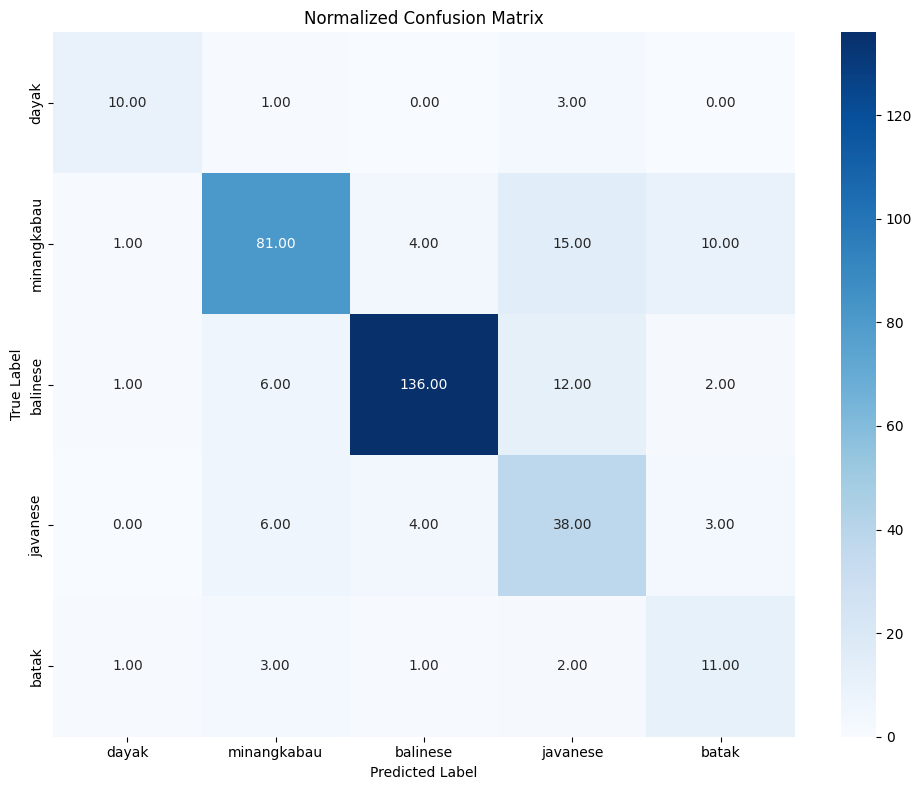

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))
 
cm = confusion_matrix(y_true, y_pred)  # pakai normalize biar per class keliatan proporsinya
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

In [20]:
class FreezeUnfreezeCBAMByType(tf.keras.callbacks.Callback):
    def __init__(self, unfreeze_epoch=5):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self.frozen = False

    def on_train_begin(self, logs=None):
        print(f"\n[INFO] Membekukan layer CBAM (Conv2D/Multiply) untuk {self.unfreeze_epoch} epoch pertama...")
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Multiply) or isinstance(layer, tf.keras.layers.Conv2D):
                layer.trainable = False
        self.frozen = True

    def on_epoch_begin(self, epoch, logs=None):
        if self.frozen and epoch == self.unfreeze_epoch:
            print(f"\n[INFO] Membuka kembali layer CBAM untuk fine-tuning penuh (mulai epoch {epoch})...")
            for layer in self.model.layers:
                if isinstance(layer, tf.keras.layers.Multiply) or isinstance(layer, tf.keras.layers.Conv2D):
                    layer.trainable = True
            self.frozen = False

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5,
                                                 patience=4,
                                                 min_lr=1e-7,
                                                 verbose=1
                                                )

base_model.trainable = True
for layer in base_model.layers[:int(len(base_model.layers) * 0.7)]: 
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE_FINETUNE), 
    loss=loss_fn, 
    metrics=['accuracy']
)

In [22]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 20,
    callbacks=[
        f1_callback, 
        reduce_lr,
        tf.keras.callbacks.ModelCheckpoint("model_EFF2V_FINETUNED.keras", save_best_only=True, monitor="val_loss", mode='min'),
        tf.keras.callbacks.EarlyStopping( 
            monitor='val_loss', 
            patience=10, 
            mode='min',
            restore_best_weights=True
        )
    ]
)

Epoch 1/50


E0000 00:00:1760190074.378708      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190074.601226      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190077.719778      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190077.888050      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190078.601520      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

21/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.6410 - loss: 0.4457

E0000 00:00:1760190187.454625      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190187.670735      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190190.690364      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760190190.965580      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6428 - loss: 0.4453
val_f1_macro: 0.6455
22/22 ━━━━━━━━━━━━━━━━━━━━ 341s 9s/step - accuracy: 0.6444 - loss: 0.4449 - val_accuracy: 0.7322 - val_loss: 0.4358 - val_f1_macro: 0.6455 - learning_rate: 1.0000e-05
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7408 - loss: 0.3815
val_f1_macro: 0.6809
22/22 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.7411 - loss: 0.3816 - val_accuracy: 0.7635 - val_loss: 0.4192 - val_f1_macro: 0.6809 - learning_rate: 1.0000e-05
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7759 - loss: 0.3236
val_f1_macro: 0.7064
22/22 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7765 - loss: 0.3227 - val_accuracy: 0.7892 - val_loss: 0.4045 - val_f1_macro: 0.7064 - learning_rate: 1.0000e-05
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7984 - loss: 0.2969
val_f1_macro: 0.7313
22/22 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7989 - loss: 0.2960 - val_accuracy: 0.8034 

              precision    recall  f1-score   support

       dayak       0.85      0.79      0.81        14
 minangkabau       0.92      0.88      0.90       111
    balinese       0.95      0.94      0.95       157
    javanese       0.71      0.86      0.78        51
       batak       0.88      0.78      0.82        18

    accuracy                           0.89       351
   macro avg       0.86      0.85      0.85       351
weighted avg       0.90      0.89      0.90       351



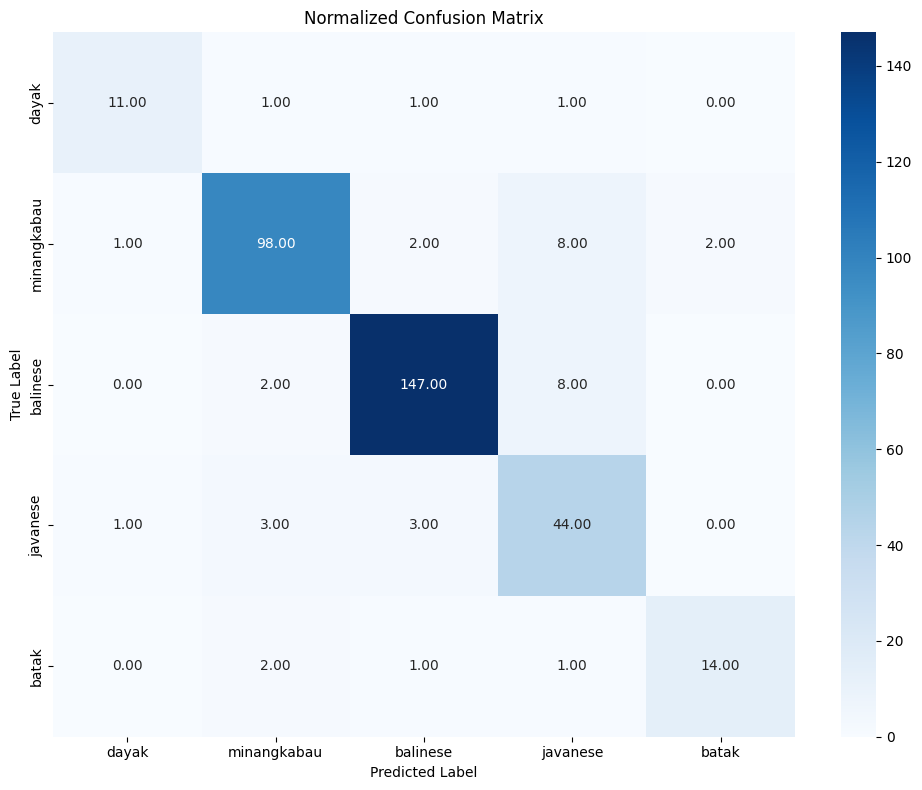

In [23]:
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)  
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

### Hard Fine Tuned

In [24]:
wrong_indices = np.where(y_pred != y_true)[0]
print(f"Jumlah salah prediksi: {len(wrong_indices)}")

hard_images = []
hard_labels = []

for idx in wrong_indices:
    img_path = df.loc[idx, "path"]  
    label_idx = df.loc[idx, "label_idx"]  

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    img = cv2.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)

    hard_images.append(img)
    hard_labels.append(label_idx)

hard_images = np.array(hard_images, dtype='float32')


Jumlah salah prediksi: 37


In [25]:
def augment_batch(images, labels):
    images = data_augmentation(images)
    return images, labels

hard_ds = tf.data.Dataset.from_tensor_slices((hard_images, hard_labels))
hard_ds = hard_ds.map(augment_batch, num_parallel_calls=tf.data.AUTOTUNE)
hard_ds = hard_ds.cache('/kaggle/working/hard_cache')
hard_ds = hard_ds.shuffle(len(hard_images), seed=SEED)
hard_ds = hard_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-6),
    loss=loss_fn,
    metrics=['accuracy']
)

history = model.fit(
    hard_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "model_EFF2V_HARD_FINETUNED.keras",
            save_best_only=True,
            monitor="val_loss",
            mode='min'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


E0000 00:00:1760193943.783503      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760193943.972554      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760193946.099009      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760193946.328671      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 192s 192s/step - accuracy: 0.4324 - loss: 1.1693 - val_accuracy: 0.8860 - val_loss: 0.3031
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4865 - loss: 0.8300 - val_accuracy: 0.8689 - val_loss: 0.3142
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4324 - loss: 0.8833 - val_accuracy: 0.8575 - val_loss: 0.3282
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5405 - loss: 0.9384 - val_accuracy: 0.8575 - val_loss: 0.3433
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4054 - loss: 0.7647 - val_accuracy: 0.8547 - val_loss: 0.3620
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5135 - loss: 0.9532 - val_accuracy: 0.8519 - val_loss: 0.3843


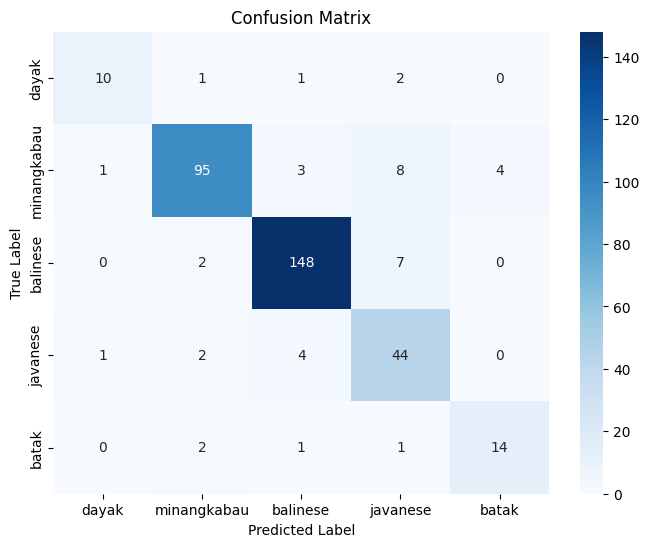

In [27]:
y_true_all = []
y_pred_all = []

for images, labels in val_ds:  
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    y_pred_all.extend(pred_labels)
    y_true_all.extend(labels.numpy())

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
y_true = np.array(y_true_all)
y_pred = np.array(y_pred_all)

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       dayak       0.83      0.71      0.77        14
 minangkabau       0.93      0.86      0.89       111
    balinese       0.94      0.94      0.94       157
    javanese       0.71      0.86      0.78        51
       batak       0.78      0.78      0.78        18

    accuracy                           0.89       351
   macro avg       0.84      0.83      0.83       351
weighted avg       0.89      0.89      0.89       351



## Update Threshold 

In [29]:
model.load_weights("/kaggle/working/model_EFF2V_FINETUNED.keras")

y_true, y_pred_probs, image_paths = [], [], []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)  # (batch, n_classes)
    y_pred_probs.append(probs)
    y_true.extend(labels.numpy())

    if hasattr(val_ds, 'file_paths'):
        image_paths.extend(val_ds.file_paths)
    elif hasattr(images, '_numpy'):
        image_paths.extend(images._numpy())

y_true = np.array(y_true)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)

best_thresholds = []
y_pred_final = np.zeros_like(y_pred_probs)

for i in range(y_pred_probs.shape[1]):
    best_f1 = 0
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 81):
        preds = (y_pred_probs[:, i] >= t).astype(int)
        f1 = f1_score((y_true == i).astype(int), preds)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds.append(best_t)
    y_pred_final[:, i] = (y_pred_probs[:, i] >= best_t).astype(int)

print("Best thresholds per class:", best_thresholds)


Best thresholds per class: [0.39, 0.43000000000000005, 0.42000000000000004, 0.47, 0.39]



Classification Report:
              precision    recall  f1-score   support

       dayak       0.54      0.93      0.68        14
 minangkabau       0.94      0.86      0.90       111
    balinese       0.97      0.94      0.95       157
    javanese       0.75      0.84      0.80        51
       batak       0.88      0.78      0.82        18

    accuracy                           0.89       351
   macro avg       0.82      0.87      0.83       351
weighted avg       0.91      0.89      0.90       351



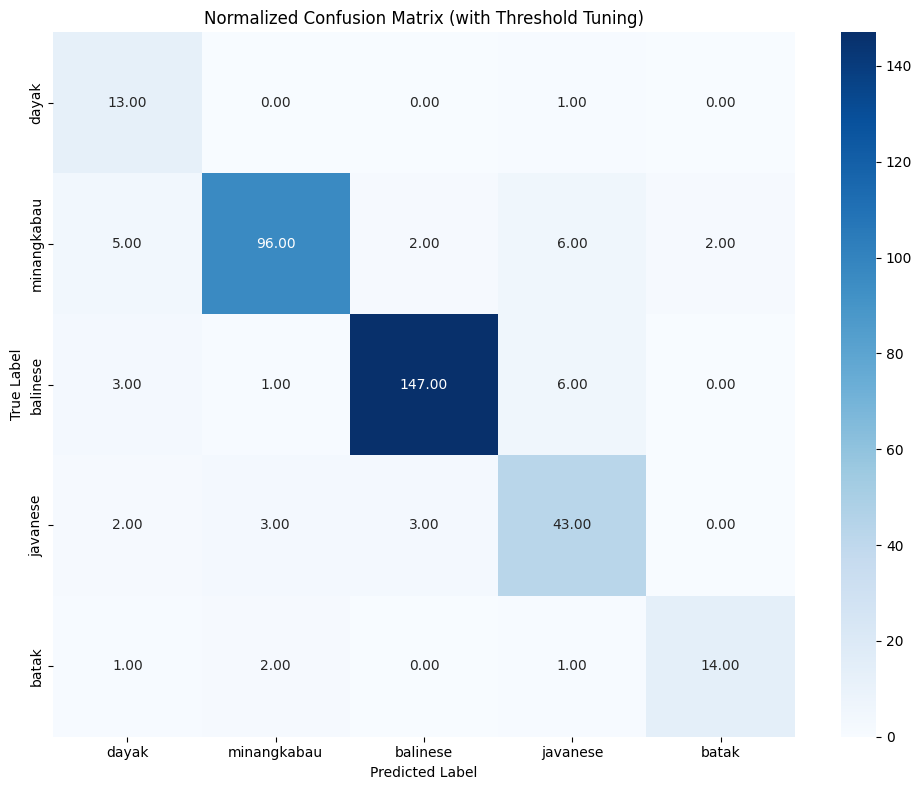

In [30]:
y_pred = np.argmax(y_pred_final, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (with Threshold Tuning)")
plt.tight_layout()
plt.show()

## Testing

In [31]:
from tqdm import tqdm

best_model_path = "/kaggle/working/model_EFF2V_HARD_FINETUNED.keras"
model.load_weights(best_model_path)

test_path = os.path.join(base_path, 'Test')
test_images = sorted(os.listdir(test_path))

predictions = []
ids = []

def load_and_preprocess_test_image(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_preprocessed = tf.keras.applications.efficientnet_v2.preprocess_input(img_resized.astype('float32'))
    img_final = np.expand_dims(img_preprocessed, 0)
    return img_final

best_thresholds = np.array(best_thresholds)  # dari threshold tuning

for img_name in tqdm(test_images, desc="Predicting Test with Thresholds"):
    img_path = os.path.join(test_path, img_name)
    img_array = load_and_preprocess_test_image(img_path)

    probs = model.predict(img_array, verbose=0)[0]  # (n_classes,)

    # Terapkan threshold per kelas
    pred_binary = (probs >= best_thresholds).astype(int)

    # Ambil kelas dengan prediksi 1 atau fallback ke max probability
    if pred_binary.sum() == 0:
        pred_class_index = np.argmax(probs)
    else:
        pred_class_index = np.argmax(pred_binary)  # kalau lebih dari 1, ambil pertama yang 1

    pred_class_name = class_names[pred_class_index]

    img_id = os.path.splitext(img_name)[0]
    ids.append(img_id)
    predictions.append(pred_class_name)

# Simpan hasil
df = pd.DataFrame({"id": ids, "style": predictions})
df = df.sort_values(by="id")
df.to_csv("submission_thresholded.csv", index=False)

print("✅ Done! Predictions with threshold saved to submission_thresholded.csv")


Predicting Test with Thresholds: 100%|██████████| 444/444 [02:07<00:00,  3.48it/s]

✅ Done! Predictions with threshold saved to submission_thresholded.csv
